In [1]:
# Import Libraries and Load Data

import zipfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ***Data Loading***

In [2]:
# download dataset
# !kaggle datasets download -d carrie1/ecommerce-data

In [3]:
# with zipfile.ZipFile('ecommerce-data.zip', 'r') as zip_ref:
#     zip_ref.extractall('ecommerce-data')
'''
This code efficiently extracts all files from `ecommerce-data.zip` into
a directory named `ecommerce-data`,
ensuring proper handling of the file through the `with` statement.
This is a common approach when dealing with compressed files in Python.
'''

'\nThis code efficiently extracts all files from `ecommerce-data.zip` into\na directory named `ecommerce-data`,\nensuring proper handling of the file through the `with` statement.\nThis is a common approach when dealing with compressed files in Python.\n'

In [4]:
# List all files in the extracted directory
# os.listdir('ecommerce-data')

In [5]:
# Read the data
df_ori = pd.read_csv('data.csv', encoding='ISO-8859-1')

# duplicate dataset
df = df_ori.copy()

# Display the top 3 rows of the data
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
print(df.shape)

(541909, 8)


In [7]:
# Check the detail information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

# ***Data Cleaning***

In [9]:
# IMV Check
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df = df.dropna()

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
# Check again after drop the IMV

df.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [12]:
# Check the duplicated rows in the dataset

df.duplicated().sum()

5225

In [13]:
# Remove the duplicated rows
df = df.drop_duplicates()

# Call the set variable after removal
df.duplicated().sum()

0

In [14]:
dateLengths = df.InvoiceDate.str.len()
dateLengths.value_counts()

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%m/%d/%Y %H:%M")
df["Invoice_Date"] = df["InvoiceDate"].dt.strftime("%m/%d/%Y")
df["Invoice_Time"] = df["InvoiceDate"].dt.strftime("%H:%M")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_Date,Invoice_Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12/01/2010,08:26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12/01/2010,08:26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26


In [15]:
#Calculating the TotalPrice per order (UnitPrice and Quantity)
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_Date,Invoice_Time,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12/01/2010,08:26,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12/01/2010,08:26,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12/01/2010,08:26,20.34


# ***Exploratory Data Analysis***
### *Before Clustering*

DRAFTtext

In [16]:
df.describe(include = 'O').T

,count,unique,top,freq
InvoiceNo,401604,22190,576339,542
StockCode,401604,3684,85123A,2065
Description,401604,3896,WHITE HANGING HEART T-LIGHT HOLDER,2058
Country,401604,37,United Kingdom,356728
Invoice_Date,401604,305,12/05/2011,3359
Invoice_Time,401604,773,13:35,1810


In [17]:
#Find out the number of orders for each country separately.
countryMask = df.groupby(['Country', 'InvoiceNo']).size().reset_index(name='order_count')
countryOrder = countryMask.groupby('Country').agg(order_count=('order_count', 'count')).sort_values(by='order_count', ascending=False)
print(countryOrder)

                      order_count
Country                          
United Kingdom              19857
Germany                       603
France                        458
EIRE                          319
Belgium                       119
Spain                         105
Netherlands                   101
Switzerland                    71
Portugal                       70
Australia                      69
Italy                          55
Finland                        48
Sweden                         46
Norway                         40
Channel Islands                33
Japan                          28
Poland                         24
Denmark                        21
Cyprus                         20
Austria                        19
Malta                          10
Singapore                      10
Unspecified                     8
Iceland                         7
USA                             7
Israel                          6
Greece                          6
Canada        

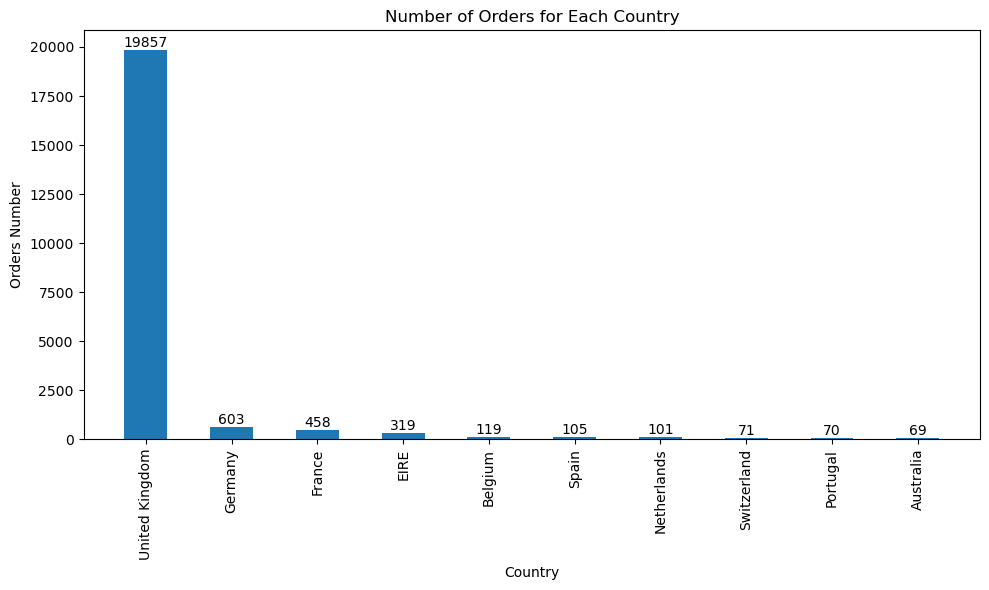

In [18]:
# Sort the DataFrame by 'order_count'in descending order and select the top 10
top10Countries = countryOrder.sort_values(by='order_count', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
barWidth = 0.5

# Depict the plot
plt.bar(np.arange(len(top10Countries.index)), top10Countries['order_count'], width=barWidth)

for i, value in enumerate(top10Countries['order_count']):
  plt.text(i, value+1, str(value), ha='center', va='bottom')

# Title & Label
plt.title('Number of Orders for Each Country')
plt.xlabel('Country')
plt.ylabel('Orders Number')

plt.xticks(np.arange(len(top10Countries.index)), top10Countries.index, rotation=90)

plt.tight_layout()
plt.show()

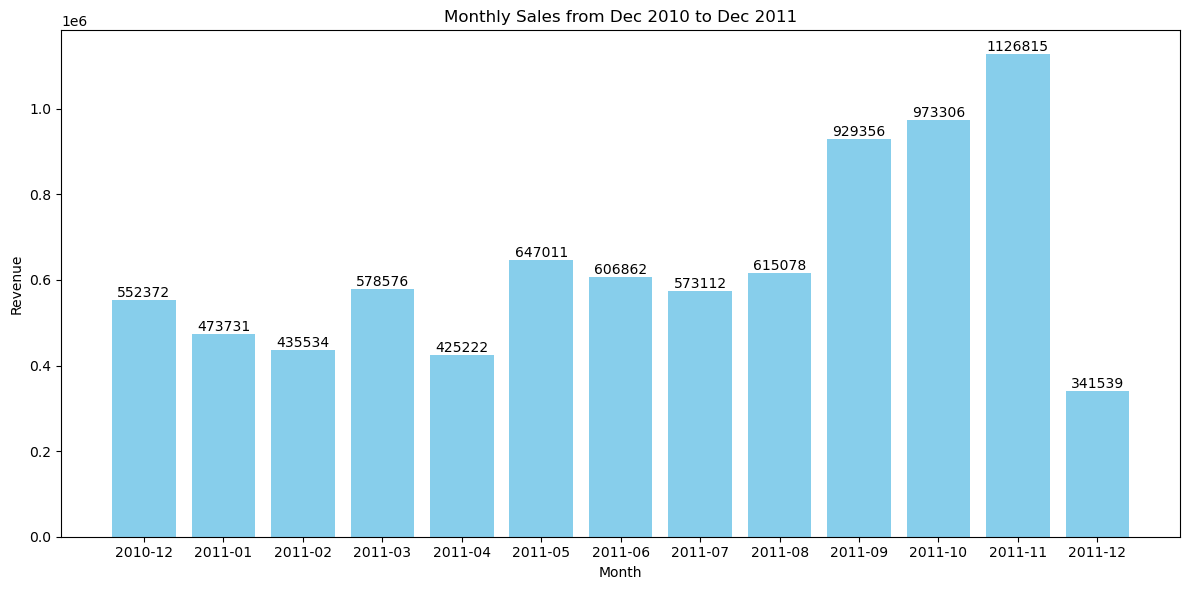

In [19]:
#Find out the total sales per month
df['Invoice_Date'] = pd.to_datetime(df['Invoice_Date'])
df['Month'] = df['Invoice_Date'].dt.to_period('M')
monthlySales = df.groupby('Month')['TotalPrice'].sum()
xLabels = monthlySales.index.strftime('%Y-%m')




plt.figure(figsize=(12, 6))
bars = plt.bar(xLabels, monthlySales, color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')
plt.title('Monthly Sales from Dec 2010 to Dec 2011')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
# Define the Top 10 products
productGrouped = df.groupby('Description')
quantityProduct = productGrouped.agg({'Quantity':'sum'})
quantityProductTop10 = quantityProduct.nlargest(10, 'Quantity')
print(quantityProductTop10)

                                    Quantity
Description                                 
WORLD WAR 2 GLIDERS ASSTD DESIGNS      53119
JUMBO BAG RED RETROSPOT                44963
ASSORTED COLOUR BIRD ORNAMENT          35215
WHITE HANGING HEART T-LIGHT HOLDER     34128
PACK OF 72 RETROSPOT CAKE CASES        33386
POPCORN HOLDER                         30492
RABBIT NIGHT LIGHT                     27045
MINI PAINT SET VINTAGE                 25880
PACK OF 12 LONDON TISSUES              25305
PACK OF 60 PINK PAISLEY CAKE CASES     24129


In [21]:
# Define the Top 10 Top Sale Revenue
topSaleRevenue = productGrouped.agg({'Quantity':'sum', 'TotalPrice':'sum'})
topSaleRevenue_top10 = topSaleRevenue.nlargest(10, 'TotalPrice')

print(topSaleRevenue_top10)

                                    Quantity  TotalPrice
Description                                             
REGENCY CAKESTAND 3 TIER               11529   132567.70
WHITE HANGING HEART T-LIGHT HOLDER     34128    93767.80
JUMBO BAG RED RETROSPOT                44963    83056.52
PARTY BUNTING                          15015    67628.43
POSTAGE                                 3002    66710.24
ASSORTED COLOUR BIRD ORNAMENT          35215    56331.91
RABBIT NIGHT LIGHT                     27045    51042.84
CHILLI LIGHTS                           9566    45915.41
PAPER CHAIN KIT 50'S CHRISTMAS         15138    41423.78
PICNIC BASKET WICKER 60 PIECES            61    39619.50


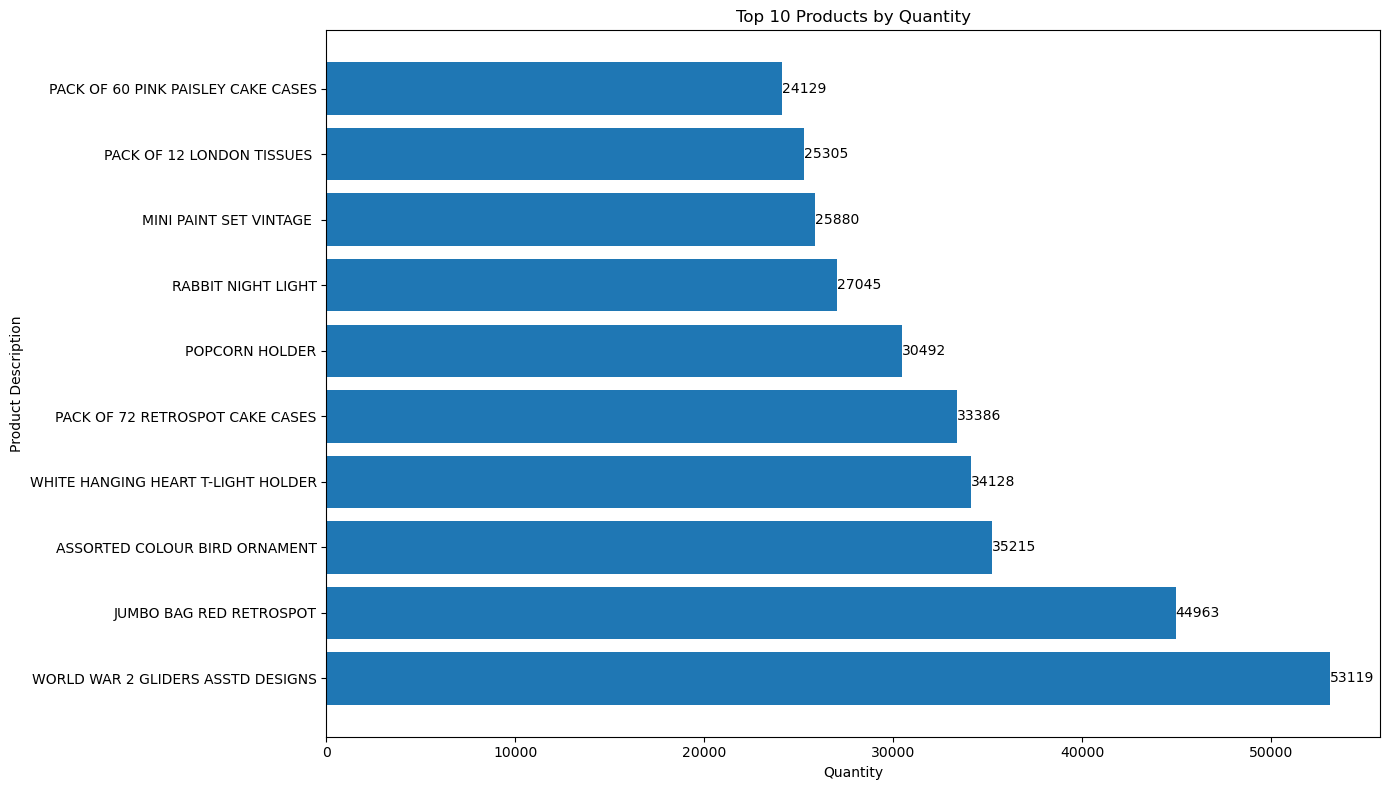

In [22]:
plt.figure(figsize=(14, 8))
plt.barh(quantityProductTop10.index, quantityProductTop10['Quantity'])

plt.title('Top 10 Products by Quantity')
plt.xlabel('Quantity')
plt.ylabel('Product Description')

for i, value in enumerate(quantityProductTop10['Quantity']):
    plt.text(value, i, str(value), ha='left', va='center')

plt.tight_layout()
plt.show()

# RFM 

In [23]:
# Initiate the RFM Analysis

# RFM Analysis, Recency(R):Days since last purchase
# Frequency(F):Total number of purchases
# Monetary Value(M):Total money of customer spent.

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     401604 non-null  object        
 1   StockCode     401604 non-null  object        
 2   Description   401604 non-null  object        
 3   Quantity      401604 non-null  int64         
 4   InvoiceDate   401604 non-null  datetime64[ns]
 5   UnitPrice     401604 non-null  float64       
 6   CustomerID    401604 non-null  float64       
 7   Country       401604 non-null  object        
 8   Invoice_Date  401604 non-null  datetime64[ns]
 9   Invoice_Time  401604 non-null  object        
 10  TotalPrice    401604 non-null  float64       
 11  Month         401604 non-null  period[M]     
dtypes: datetime64[ns](2), float64(3), int64(1), object(5), period[M](1)
memory usage: 39.8+ MB


In [24]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Invoice_Date,TotalPrice
count,401604.000000,401604,401604.000000,401604.000000,401604,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818,2011-07-09 22:54:08.358084096,20.613638
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000,2010-12-01 00:00:00,-168469.600000
25%,2.000000,2011-04-06 15:02:00,1.250000,13939.000000,2011-04-06 00:00:00,4.250000
50%,5.000000,2011-07-29 15:40:00,1.950000,15145.000000,2011-07-29 00:00:00,11.700000
75%,12.000000,2011-10-20 11:58:30,3.750000,16784.000000,2011-10-20 00:00:00,19.800000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,2011-12-09 00:00:00,168469.600000
std,250.283037,NaN,69.764035,1714.006089,NaN,430.352218


In [25]:
#Last date available in the df
df['InvoiceDate'].max()

current = pd.Timestamp(datetime(2010, 12, 1))
print(current)

2010-12-01 00:00:00


In [26]:
RFMScore = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (current - x.max()).days,
                                            'InvoiceNo': lambda x: x.count(),
                                          'TotalPrice': lambda x: x.sum()})

RFMScore.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,-49,2,0.00
12347.0,-372,182,4310.00
12348.0,-299,31,1797.24
12349.0,-356,73,1757.55
12350.0,-64,17,334.40


In [27]:
# Renaming the columns for better understanding of RFM
RFMScore.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Monetary'},inplace = True)

In [28]:
RFMScore.reset_index()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,-49,2,0.00
1,12347.0,-372,182,4310.00
2,12348.0,-299,31,1797.24
3,12349.0,-356,73,1757.55
4,12350.0,-64,17,334.40
...,...,...,...,...
4367,18280.0,-97,10,180.60
4368,18281.0,-194,7,80.82
4369,18282.0,-367,13,176.60
4370,18283.0,-371,721,2045.53


In [29]:
RFMScore.describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,-282.418801,91.858188,1893.531433
std,100.772139,229.223566,8218.696204
min,-374.000000,1.000000,-4287.630000
25%,-358.000000,17.000000,291.795000
50%,-324.000000,41.000000,644.070000
75%,-231.000000,99.250000,1608.335000
max,-1.000000,7812.000000,279489.020000


In [30]:
# Extract the quantiles of R, F, and M
quantiles = RFMScore.quantile(q=[0.25,0.50,0.75])

# Display the quantile values
print(quantiles)

      Recency  Frequency  Monetary
0.25   -358.0      17.00   291.795
0.50   -324.0      41.00   644.070
0.75   -231.0      99.25  1608.335


In [31]:
# Converting to dictionary format
quantiles = quantiles.to_dict()

# Display after conversion
quantiles

{'Recency': {0.25: -358.0, 0.5: -324.0, 0.75: -231.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.25},
 'Monetary': {0.25: 291.795, 0.5: 644.0699999999999, 0.75: 1608.335}}

In [32]:
# Creating a function to group the customers into 4 based on Recency value
# x = value
# p = recency, monetary, frequency
# d = quartiles dict
# d[p][0.25] retrieves the value of p from dict d using the indices [0.25], [0.5], and [0.75]
# Recency: the closer the last transaction, the better

def RecencyScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [33]:
# Creating a function to group the customers into 4 based on Frequency and Monetary values
# Frequency and Monetary: The larger the number of transactions and the total transaction amount, the better it is

def FreqMonetScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1


In [34]:
RFMScore.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [35]:
# Applying the created function on the respective columns
# Recency_Score(x,p,d):
# x = value
# p = recency, monetary_value, frequency
# d = quartiles dict
RFMScore['R'] = RFMScore['Recency'].apply(RecencyScore, args = ('Recency',quantiles))
RFMScore['F'] = RFMScore['Frequency'].apply(FreqMonetScore, args = ('Frequency',quantiles))
RFMScore['M'] = RFMScore['Monetary'].apply(FreqMonetScore, args = ('Monetary',quantiles))

In [36]:
# Display the DataFrame of RFM
RFMScore

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,-49,2,0.00,4,4,4
12347.0,-372,182,4310.00,1,1,1
12348.0,-299,31,1797.24,3,3,1
12349.0,-356,73,1757.55,2,2,1
12350.0,-64,17,334.40,4,4,3
...,...,...,...,...,...,...
18280.0,-97,10,180.60,4,4,4
18281.0,-194,7,80.82,4,4,4
18282.0,-367,13,176.60,1,4,4


In [37]:
#Creating a new field 'RFMValue' to split the customers into 10 segments
RFMScore['RFMValue'] = RFMScore[['R','F','M']].sum(axis = 1)

In [38]:
RFMScore['RFMGroup'] = RFMScore.R.map(str) + RFMScore.F.map(str) + RFMScore.M.map(str)

In [39]:
RFMScore.reset_index()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMValue,RFMGroup
0,12346.0,-49,2,0.00,4,4,4,12,444
1,12347.0,-372,182,4310.00,1,1,1,3,111
2,12348.0,-299,31,1797.24,3,3,1,7,331
3,12349.0,-356,73,1757.55,2,2,1,5,221
4,12350.0,-64,17,334.40,4,4,3,11,443
...,...,...,...,...,...,...,...,...,...
4367,18280.0,-97,10,180.60,4,4,4,12,444
4368,18281.0,-194,7,80.82,4,4,4,12,444
4369,18282.0,-367,13,176.60,1,4,4,9,144
4370,18283.0,-371,721,2045.53,1,1,1,3,111


In [40]:
#Grouping the 10 segments of customers into 4 groups and naming them
CustomerLevel = ['Platinum','Diamond','Gold','Silver']
scoreCuts = pd.qcut(RFMScore.RFMValue, q=4, labels=CustomerLevel)
RFMScore['Customer_Level'] = scoreCuts.values
RFMScore = RFMScore.reset_index()
RFMScore

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMValue,RFMGroup,Customer_Level
0,12346.0,-49,2,0.00,4,4,4,12,444,Silver
1,12347.0,-372,182,4310.00,1,1,1,3,111,Platinum
2,12348.0,-299,31,1797.24,3,3,1,7,331,Diamond
3,12349.0,-356,73,1757.55,2,2,1,5,221,Platinum
4,12350.0,-64,17,334.40,4,4,3,11,443,Silver
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,-97,10,180.60,4,4,4,12,444,Silver
4368,18281.0,-194,7,80.82,4,4,4,12,444,Silver
4369,18282.0,-367,13,176.60,1,4,4,9,144,Gold
4370,18283.0,-371,721,2045.53,1,1,1,3,111,Platinum


In [91]:
RFMScore['CustomerID'] = RFMScore['CustomerID'].astype(int)
RFMScore['RFMGroup'] = RFMScore['RFMGroup'].astype(int)
RFMScore['Customer_Level'] = RFMScore['Customer_Level'].astype('object')

### Handling Outlier

In [92]:
RFMScore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4372 non-null   int32  
 1   Recency         4372 non-null   int64  
 2   Frequency       4372 non-null   int64  
 3   Monetary        4372 non-null   float64
 4   R               4372 non-null   int64  
 5   F               4372 non-null   int64  
 6   M               4372 non-null   int64  
 7   RFMValue        4372 non-null   int64  
 8   RFMGroup        4372 non-null   int32  
 9   Customer_Level  4372 non-null   object 
dtypes: float64(1), int32(2), int64(6), object(1)
memory usage: 307.5+ KB


In [93]:
RFMScore.nunique()

CustomerID        4372
Recency            304
Frequency          466
Monetary          4314
R                    4
F                    4
M                    4
RFMValue            10
RFMGroup            62
Customer_Level       4
dtype: int64

In [94]:
print(RFMScore.shape)

(4372, 10)


In [95]:
# mempersiapkan kolom normal, skew, dan extreme
normal = []
skew = []
extreme = []

# looping pemanggilan
for i in RFMScore.columns.to_list():
    if RFMScore[i].nunique()>4:
        skewness = RFMScore[i].skew()
        if -0.5 < skewness < 0.5:
            normal.append(i)
        elif -1 <= skewness <= -0.5 or 0.5 <= skewness <=1:
            skew.append(i)
        elif skewness < 1 or skewness > 1:
            extreme.append(i)
        
# nge print panggilan normal ,skew ,extreme
print('normal:', normal)
print('skew:', skew)
print('extreme skew:', extreme)

normal: ['CustomerID', 'RFMValue', 'RFMGroup']
skew: []
extreme skew: ['Recency', 'Frequency', 'Monetary']


In [96]:
RFMScore_winso = RFMScore

In [97]:
winsoriser_extreme = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=extreme)

In [98]:
RFMS_capped = winsoriser_extreme.fit_transform(RFMScore_winso)

Recency - Before Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


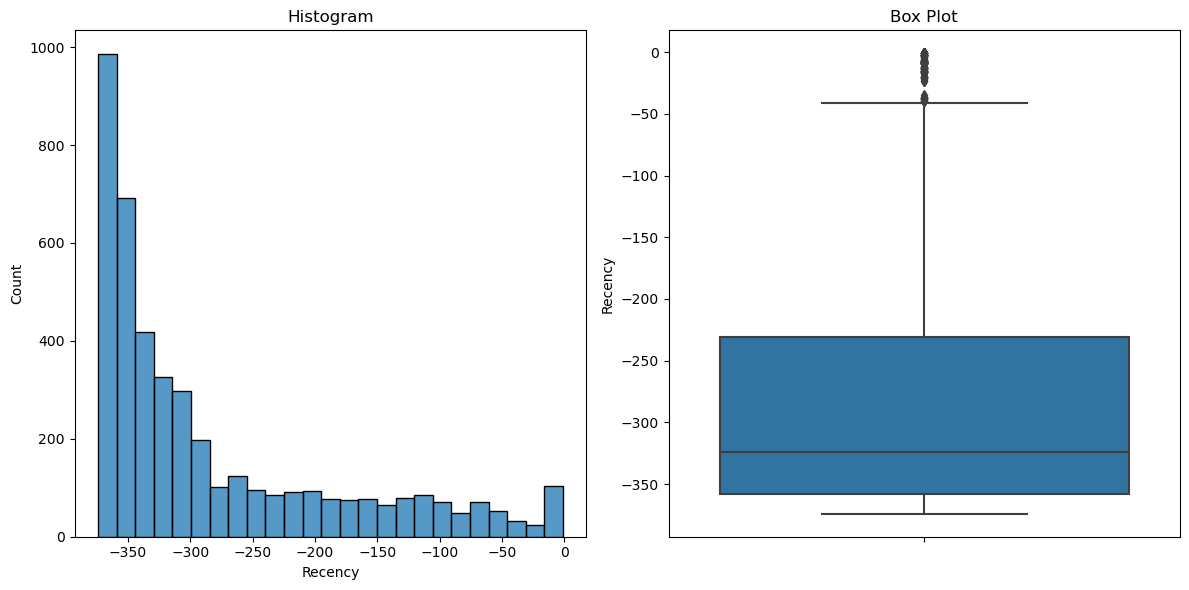


 Recency - After Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


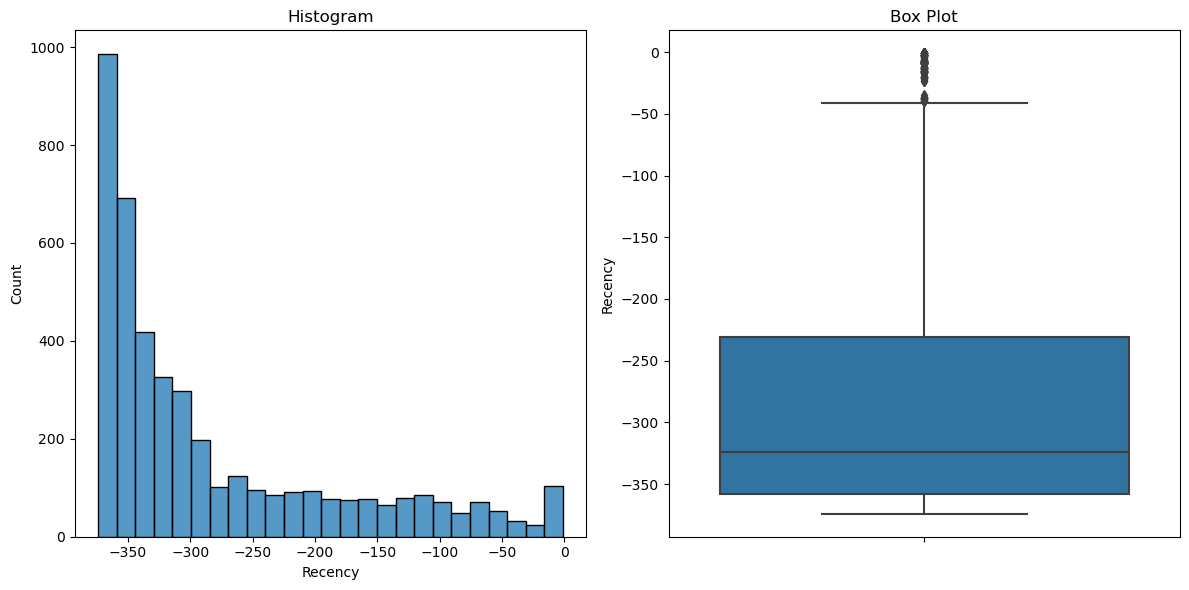

Frequency - Before Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


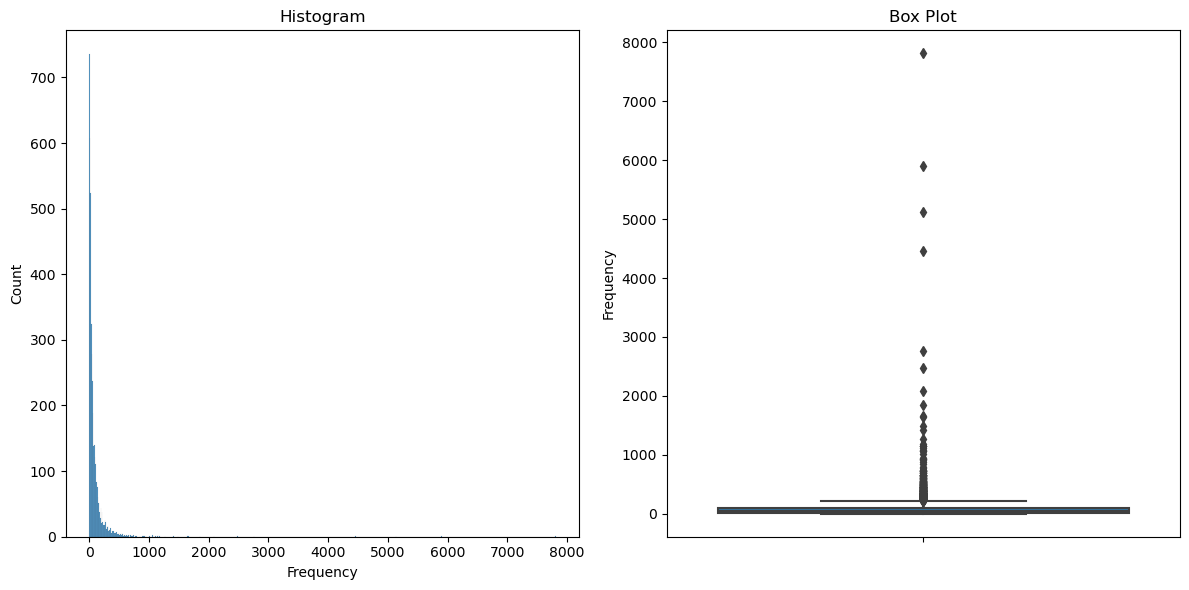


 Frequency - After Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


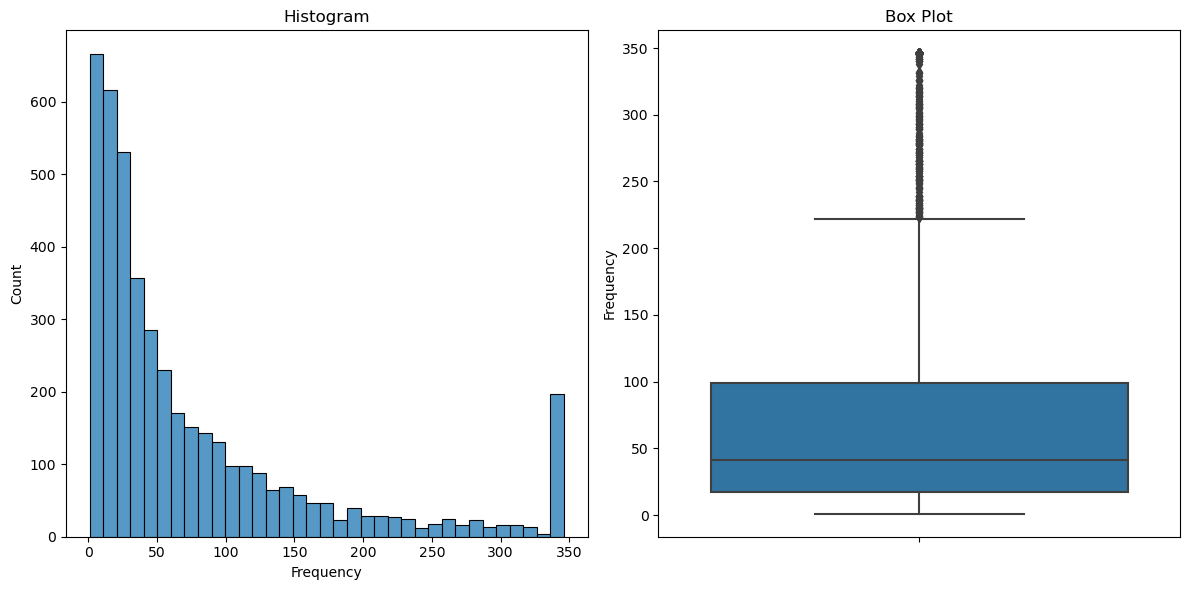

Monetary - Before Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


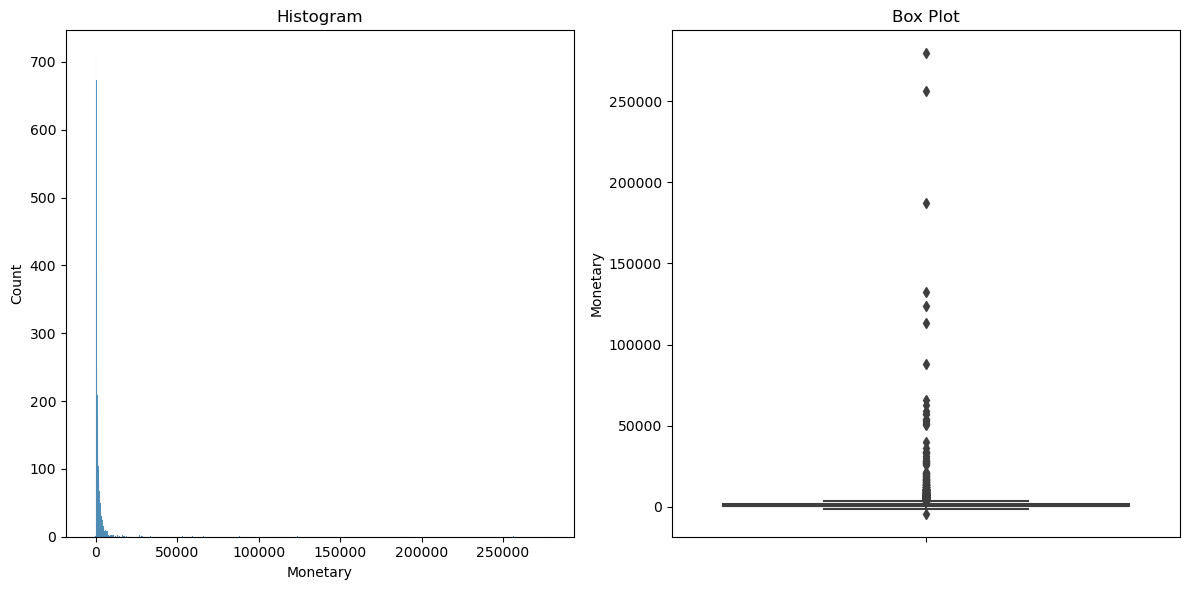


 Monetary - After Capping


c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


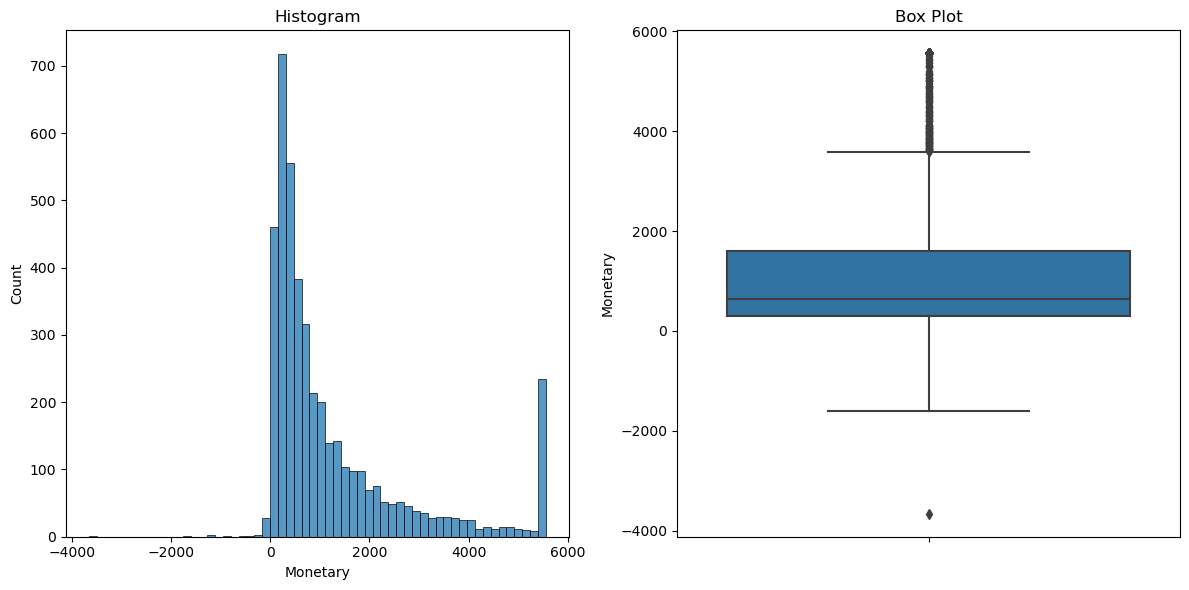

In [99]:
# Check the distribution before and after capping
def diagnostic_plots(RFMScore, feature):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Histogram
    sns.histplot(RFMScore[feature], ax=axes[0])
    axes[0].set_title('Histogram')

    # Box plot
    sns.boxplot(y=RFMScore[feature], ax=axes[1])
    axes[1].set_title('Box Plot')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
    
print('Recency - Before Capping')
diagnostic_plots(RFMScore, 'Recency')

print('\n Recency - After Capping')
diagnostic_plots(RFMS_capped, 'Recency')

print('Frequency - Before Capping')
diagnostic_plots(RFMScore, 'Frequency')

print('\n Frequency - After Capping')
diagnostic_plots(RFMS_capped, 'Frequency')

print('Monetary - Before Capping')
diagnostic_plots(RFMScore, 'Monetary')

print('\n Monetary - After Capping')
diagnostic_plots(RFMS_capped, 'Monetary')

In [100]:
# # membuat fungsi def drop outliers normal
def drop_outliers_normal(RFMS_capped, normal):
    for col in normal:
        avg = RFMS_capped[col].mean()
        std = RFMS_capped[col].std()
        upper_limit =  avg + 3 * std
        lower_limit = avg - 3 * std
        RFMS_capped.drop(RFMS_capped[(RFMS_capped[col] > upper_limit) | (RFMS_capped[col] < lower_limit)].index, inplace=True)

In [101]:
print(RFMS_capped.shape)

(4372, 10)


In [102]:
# Splitting numeric columns and categorical columns

num_columns = RFMS_capped.select_dtypes(include=np.number).columns.tolist()
cat_columns = RFMS_capped.select_dtypes(include=['object']).columns.tolist()

RFMScore_num =RFMScore[num_columns]
RFMScore_cat =RFMScore[cat_columns]

print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'RFMValue', 'RFMGroup']
Cat Columns :  ['Customer_Level']


In [104]:
# scaling
model_scaler = StandardScaler()
model_scaler.fit(num_columns) #.fit() hanya boleh dilakukan terhadap train, tidak boleg di test - set
#melakukan proses perubahan skala
RFMS_scaled = model_scaler.transform(num_columns)
RFMS_scaled = pd.DataFrame(RFMS_scaled, columns=df.columns)
RFMS_scaled

ValueError: could not convert string to float: 'CustomerID'

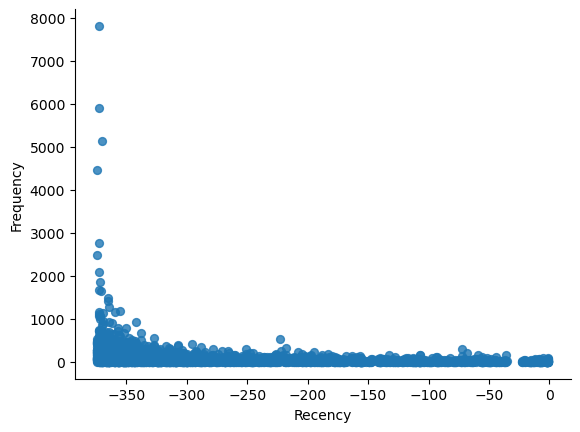

In [ ]:
# @title Recency vs Frequency

from matplotlib import pyplot as plt
RFMScore.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

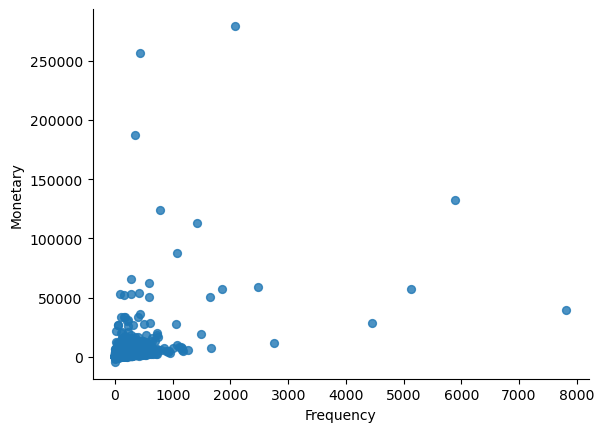

In [ ]:
# @title Frequency vs Monetary

from matplotlib import pyplot as plt
RFMScore.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Displaying the number of customers in each group
customerGroup = RFMScore['Customer_Level'].value_counts().sort_values()

# Call the set variable
customerGroup

Customer_Level
Silver       781
Gold         985
Platinum    1281
Diamond     1325
Name: count, dtype: int64

c:\Users\adhy arya\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


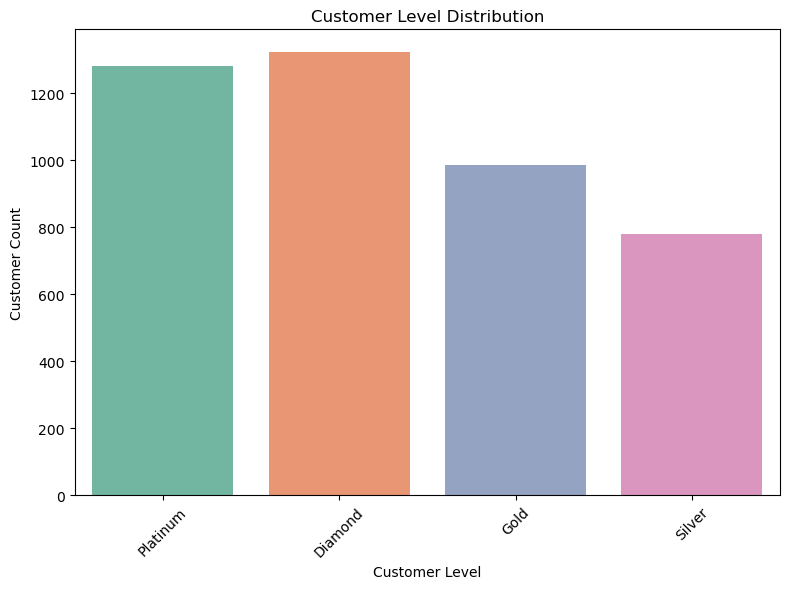

In [ ]:
#Displaying the customer groups and their counts in a barchart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=customerGroup.index, y=customerGroup.values, palette="Set2")

plt.title('Customer Level Distribution')
plt.xlabel('Customer Level')
plt.ylabel('Customer Count')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()